# Refactorización del Acercamiento del Problema a Abordar

Debido a las similitudes entre los problemas que los grupos abordaron en la sección, se tomo la decisión de cambiar el acercamiento al problema. Enfocándonos en lo que es el ajuste de precios de productos con base en distintas variables que puedan tener influencia significativa en esto. Para lograr esto de una manera eficiente se realizará un análisis a profundidad que nos a ayude a comprender de mejor manera esto para mostrar resultados y recomendaciones relevantes.

### Objetivo

El objetivo del modelo es predecir un precio óptimo en funciónd e las características del producto, ubicación del ccliente, tipo de cliente y pago, comportamiento y satisfacción y tiempos de entrega

### Variables en consideración

Las variables que se tienen a disponibles para realizar este análisis son product_category_name_english product_weight_g, product_photos_qty, product_name_lenght, product_description_lenght, customer_city, customer_state, payment_type, payment_value, payment_installments, seller_city, seller_state, freight_value, order_estimated_delivery_date, order_delivered_customer_date, review_score y order_purchase_timestamp. Pero primero realizaremos una matriz de correlación para validarlo.

### Matriz de correlación
Se realizará una matriz de correlación para poder identificar qué variables númericas impactan más nuestra variable objetivo, price. 

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\lpmon\AppData\Local\Temp\ipykernel_22604\499661469.py:5: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("..\data_clean\olist_dataset_unificado_clean.csv", parse_dates=[


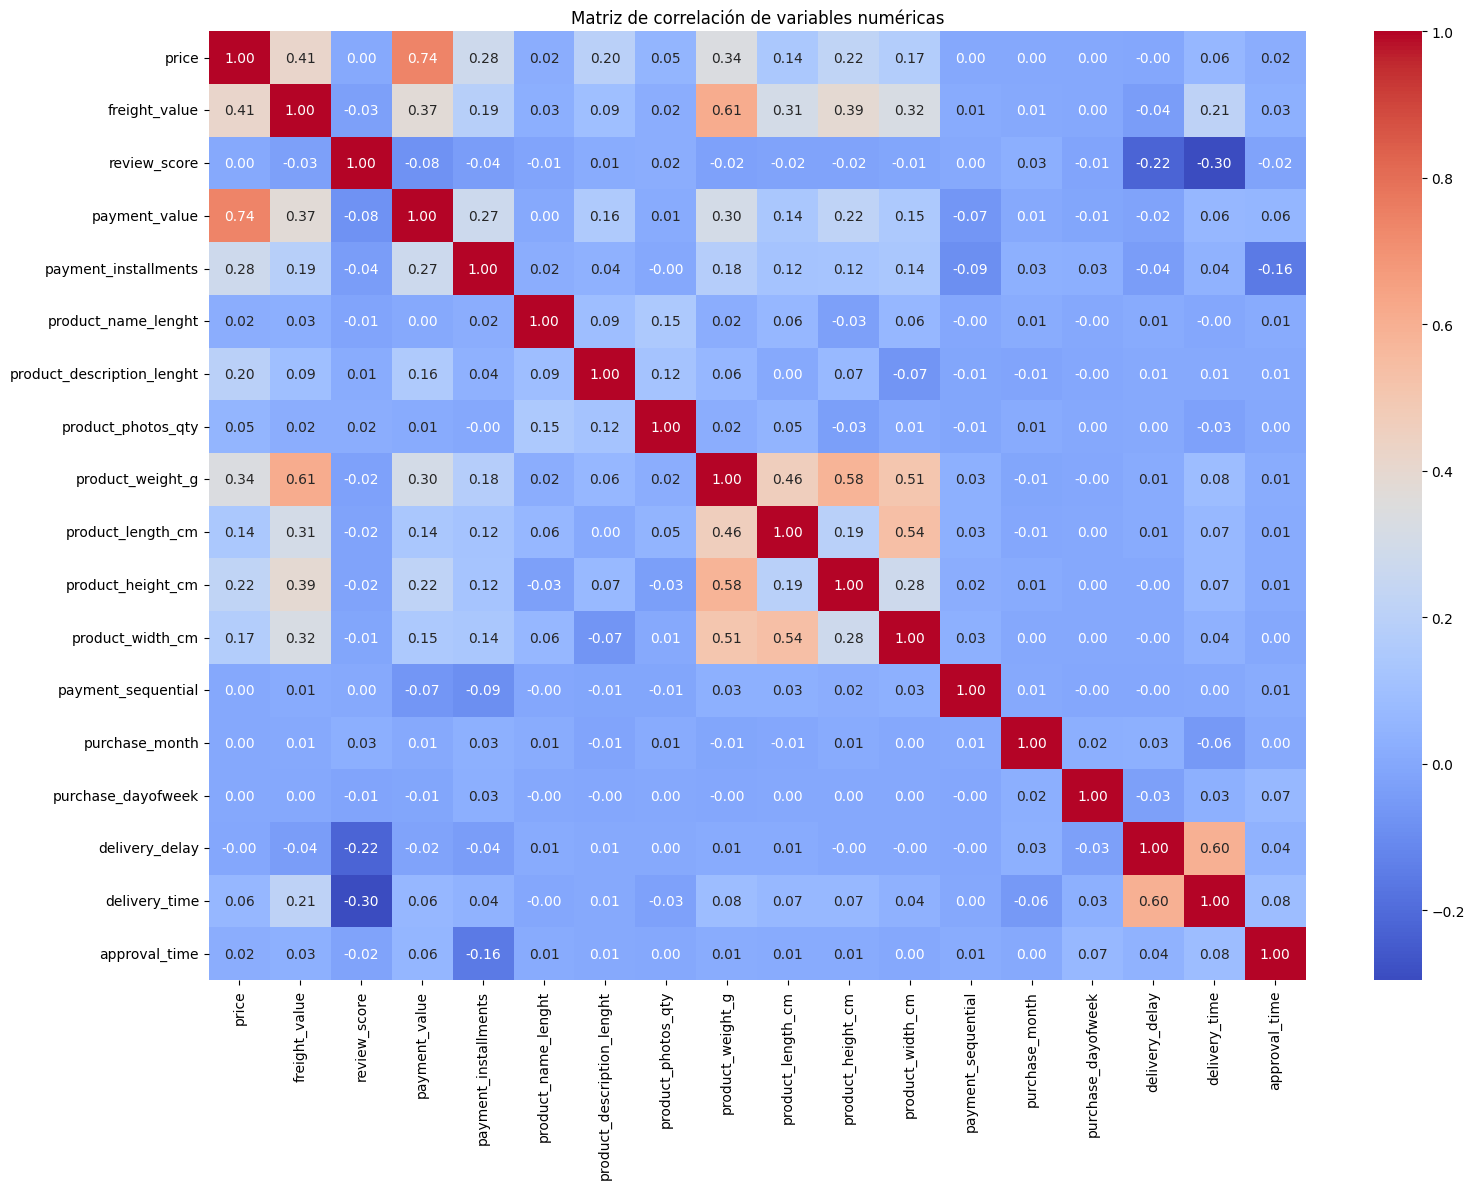

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("..\data_clean\olist_dataset_unificado_clean.csv", parse_dates=[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_creation_date",
    "review_answer_timestamp"
])

# === FEATURES TEMPORALES ===
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_dayofweek"] = df["order_purchase_timestamp"].dt.dayofweek
df["delivery_delay"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["delivery_time"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["approval_time"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.total_seconds() / 3600

# === FILTRO DE VARIABLES NUMÉRICAS ===
numericas = [
    "price", "freight_value", "review_score", "payment_value", "payment_installments",
    "product_name_lenght", "product_description_lenght", "product_photos_qty",
    "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm",
    "payment_sequential", "purchase_month", "purchase_dayofweek",
    "delivery_delay", "delivery_time", "approval_time"
]
df_numerico = df[numericas].dropna()
corr = df_numerico.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación de variables numéricas")
plt.tight_layout()
plt.show()

Para predecir el precio, las variables más útiles serán:

- payment_value (el mejor predictor),

- freight_value,

- product_weight_g,

- payment_installments.

Otras como review_score, purchase_dayofweek o approval_time no son buenas predictoras del precio directamente.

In [52]:
categoricas = [
    "customer_state", "seller_state", "payment_type", "product_category_name_english"
]

df_modelo = df[categoricas + numericas].dropna()
df_codificado = pd.get_dummies(df_modelo, drop_first=True)
corr_codificado = df_codificado.corr()
corr_price = corr_codificado["price"].sort_values(ascending=False)
print(corr_price.head(20))


price                                                                  1.000000
payment_value                                                          0.737532
freight_value                                                          0.414298
product_weight_g                                                       0.338484
payment_installments                                                   0.277701
product_category_name_english_computers                                0.233039
product_height_cm                                                      0.222752
product_description_lenght                                             0.199166
product_width_cm                                                       0.172951
seller_state_BA                                                        0.143472
product_length_cm                                                      0.142693
product_category_name_english_watches_gifts                            0.103054
product_category_name_english_home_appli

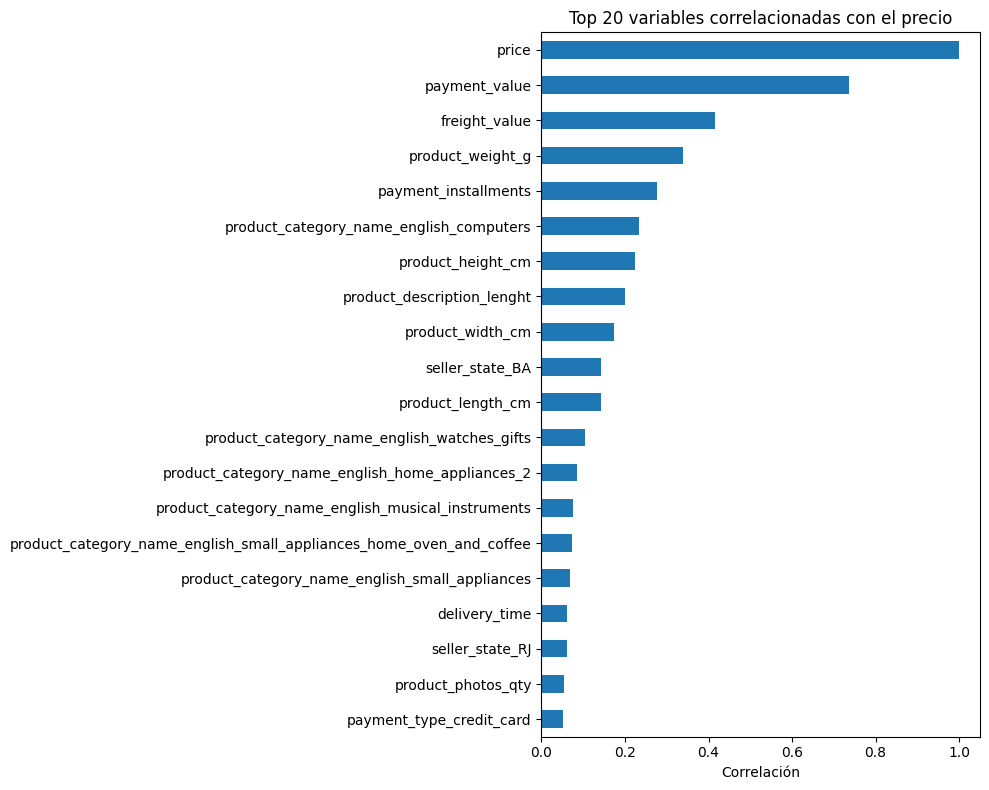

In [53]:
# Graficar top 20
corr_price.head(20).plot(kind='barh', figsize=(10, 8), title='Top 20 variables correlacionadas con el precio')
plt.xlabel("Correlación")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


El gráfico muestra que el valor total pagado (payment_value) es la variable más fuertemente relacionada con el precio, seguida por el costo de envío (freight_value) y el peso del producto (product_weight_g). Estas variables están directamente vinculadas al valor económico del producto. Además, se observa que ciertas categorías como computers y watches_gifts, así como características físicas del producto (alto, ancho y largo), también influyen en el precio. Finalmente, la región del vendedor y el tipo de pago aportan señales adicionales, aunque con menor fuerza. Este análisis confirma que tanto los factores físicos como logísticos y de categoría impactan significativamente en la formación del precio.

En base a este análisis se pueden observar que las variables payment_value, freight_value, product_weight_g, payment_installments reflejan los componentes del costo y por lo tanto estan altamente correlacionadas con el precio. también es importante mencionar que algunas categorías como computers, watches gifrs, home appliances y musical instruments suelen tener precios más altos.

### Implementación de Modelos de Regresión

Luego de identificar las variables relevantes identficadas se utilizarán tres modelos de regresión: RandomForestRegresor para realizar la interpretación y precisión y XGBoost para un rendimiento más afinado y Linear Regression para tener un punto de comparación

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

columnas_utiles = numericas + categoricas + ["price"]
df_filtrado = df[columnas_utiles].dropna()

df_dummies = pd.get_dummies(df_filtrado, columns=categoricas, drop_first=True)

X = df_dummies.drop("price", axis=1)
y = df_dummies["price"]
X = X.astype("float32")
y = y.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# remove this so it runs as before
y_train = y_train.iloc[:, 0]
y_test = y_test.iloc[:, 0]

print(type(y))
print(y.shape)


<class 'pandas.core.frame.DataFrame'>
(115730, 2)


Random Forest muestra que las variables dominantes son payment_value y freight_value. Asimismo, es importante mencionar que algunas carácterísticas físicas como product_weight_g y description_length tambien son importantes.

In [70]:
#Modelos a utilizar
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}
resultados = {}

In [71]:
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados[nombre] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

resultados_df = pd.DataFrame(resultados).T
print("\nResultados del modelo:")
print(resultados_df)

#Random Forest
modelo_arbol = modelos["Random Forest"]
importancias = pd.Series(modelo_arbol.feature_importances_, index=X.columns).sort_values(ascending=False)


Resultados del modelo:
                         MAE        RMSE        R2
Linear Regression  52.357632  120.183799  0.602291
Random Forest      15.140725   53.666793  0.920698
XGBoost            25.995214   73.336200  0.851915


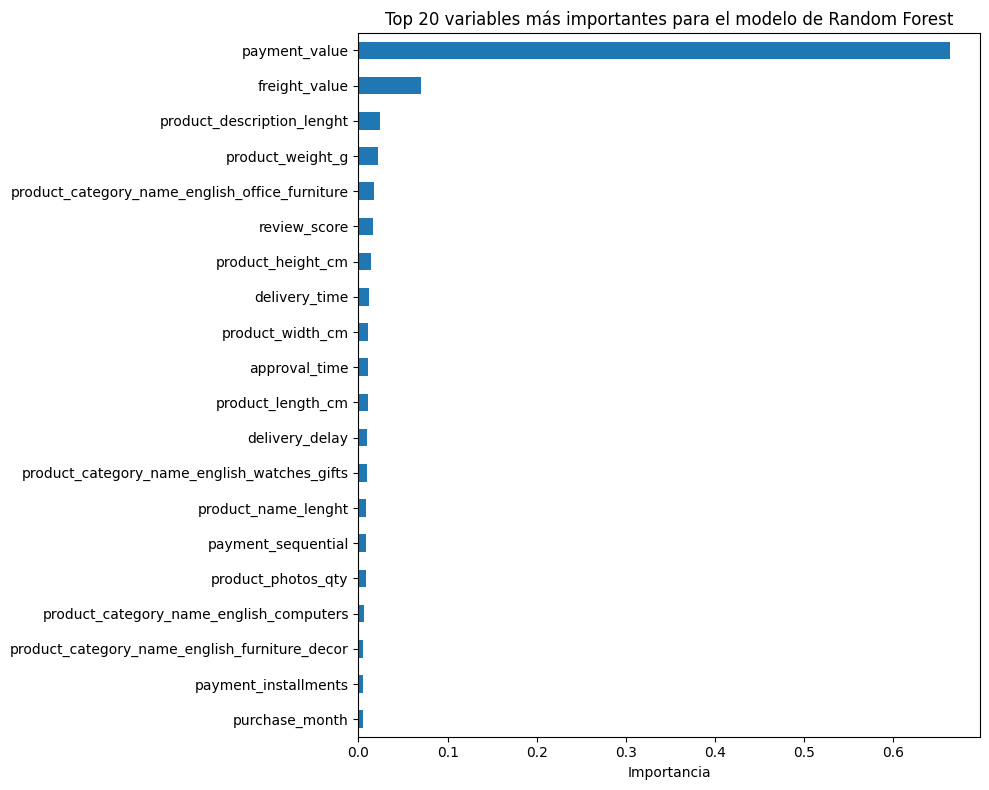

In [57]:

plt.figure(figsize=(10, 8))
importancias.head(20).plot(kind="barh")
plt.title("Top 20 variables más importantes para el modelo de Random Forest")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


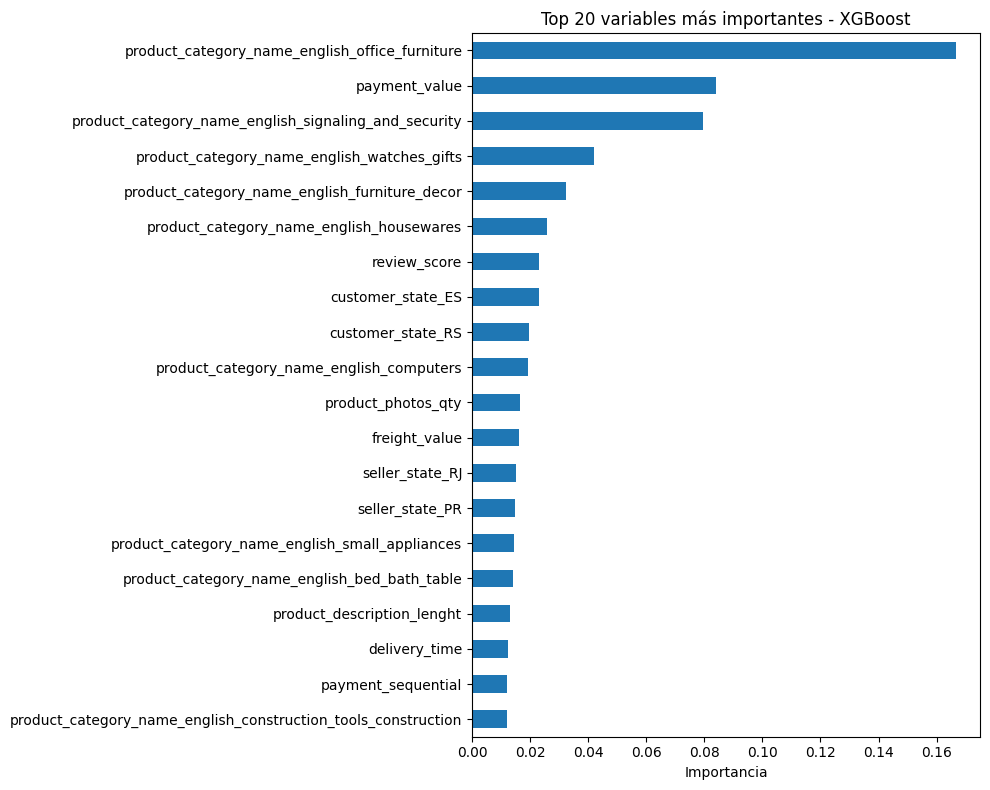

In [58]:
modelo_xgb = modelos["XGBoost"]
importancias_xgb = pd.Series(modelo_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importancias_xgb.head(20).plot(kind="barh")
plt.title("Top 20 variables más importantes - XGBoost")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


XGBoost muestra mucho peso en lo que son las categorías del producto como office_furniture_signaling_and_security y la ubicación del vendedor seller_state_* que más adelante nos puede ayudar en la diferenciación de precios en base a las categorías y regiones.

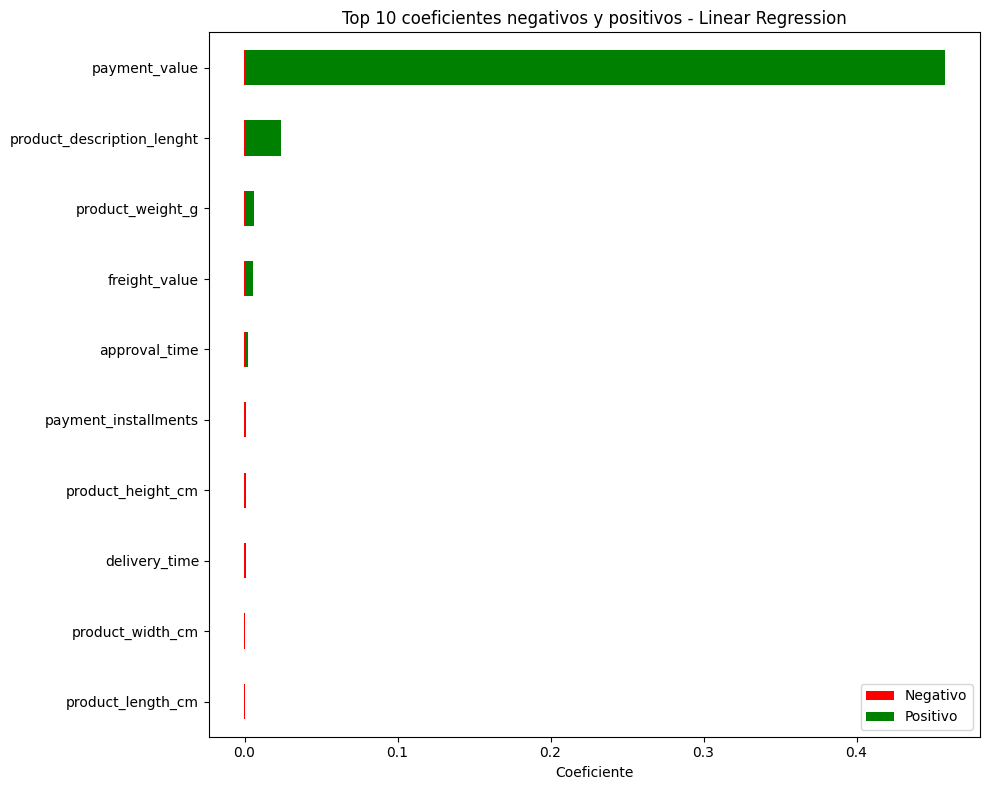

In [59]:
modelo_lr = modelos["Linear Regression"]
coeficientes = pd.Series(modelo_lr.coef_, index=X.columns).sort_values()

plt.figure(figsize=(10, 8))
coeficientes.head(10).plot(kind="barh", color="red", label="Negativo")
coeficientes.tail(10).plot(kind="barh", color="green", label="Positivo")
plt.title("Top 10 coeficientes negativos y positivos - Linear Regression")
plt.xlabel("Coeficiente")
plt.legend()
plt.tight_layout()
plt.show()

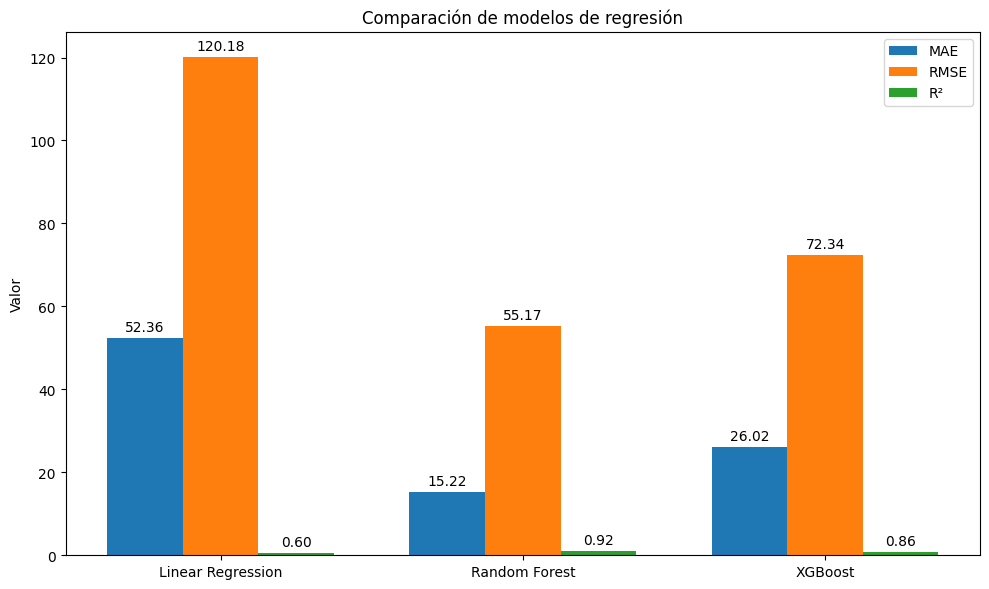

In [60]:
modelos_list = ["Linear Regression", "Random Forest", "XGBoost"]
mae = [52.36, 15.22, 26.02]
rmse = [120.18, 55.17, 72.34]
r2 = [0.6023, 0.9162, 0.8559]

x = np.arange(len(modelos_list))
width = 0.25 

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, mae, width, label='MAE')
bars2 = ax.bar(x, rmse, width, label='RMSE')
bars3 = ax.bar(x + width, r2, width, label='R²')

ax.set_ylabel("Valor")
ax.set_title("Comparación de modelos de regresión")
ax.set_xticks(x)
ax.set_xticklabels(modelos_list)
ax.legend()

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Linea regresión muestra una gran dependencia de lo que es paymente_value y description_length.En base a los resultados obtenidos podemos observar que Linear Regression mostró un subjauste notable. Random Forest muestra un muy buen desempeño y un error bastante bajo. XGBoost también mostró un desempeño bastante fuerte y levemente inferior a Random Forest.

### Modelos de Clasificacion

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
import matplotlib.pyplot as plt

# Crear etiqueta binaria: 1 si el precio es igual o superior al predicho
rf_pred =  modelos["Random Forest"].predict(X)
y_class = (y >= rf_pred).astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)
y_score = clf.predict_proba(X_test_c)[:, 1]  


print(confusion_matrix(y_test_c, y_pred_c))
print(classification_report(y_test_c, y_pred_c))

cm = confusion_matrix(y_test_c, y_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Precio incorrecto", "Precio correcto"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Clasificador de Precio")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test_c, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="orange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Clasificador de Precio")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Unable to coerce to Series, length must be 2: given 115730

En base a los resultados se puede observar que la exactitud global es del 78% lo que es bueno. La clase 1 que corresponde a la predicción correcta muestra un muy buen recall con un 89%, indicando que el modelo detecta bien cuándo un precio está alineado con lo esperado. La clase 0 tiene un menor recall, del 64% al realizar una predicción incorrecta. Esto nos da una oportunidad de mejora para detectar productos que se encuentren mal posicionados.

Con respecto a la curva ROC y AUC de 0.85 nos indica que se tiene un modelo bastante sólido ya que esta se eleva claramente por encima de la línea base, indicando que el modelo distingue bien entre precios correctos e incorrectos.

### Validación Cruzada con Rarndom Forest

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores_rf = cross_val_score(clf_rf, X, y_class, cv=5, scoring='accuracy')

print("Accuracies (Random Forest - CV 5 folds):", scores_rf)
print("Promedio de accuracy:", scores_rf.mean())


Accuracies (Random Forest - CV 5 folds): [0.66901408 0.67065584 0.670267   0.66979176 0.67139031]
Promedio de accuracy: 0.67022379676834


### Red Neuronal con MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42))
])
scores_mlp = cross_val_score(mlp_pipeline, X, y_class, cv=5, scoring="accuracy")

print("Accuracies (Red Neuronal - CV 5 folds):", scores_mlp)
print("Promedio de accuracy:", scores_mlp.mean())


Accuracies (Red Neuronal - CV 5 folds): [0.64205478 0.63946254 0.6422708  0.63704312 0.64404217]
Promedio de accuracy: 0.6409746824505314


Aumentar las iteraciones de 300 a 1000 merjoró un poco el rendimeinto de la red neufonal frente a la versión ajustada con GridSeach, pero aún así sigue por debajo de Random Forest. Es importante mencionar que es estable y usable si se decide utilizar como método alternativo.

### Búsqueda de Hiperparámetros con GridSeachCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'mlp__hidden_layer_sizes': [(64,), (128, 64), (64, 32)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(mlp_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X, y_class)

print("Mejor combinación:", grid.best_params_)
print("Mejor accuracy:", grid.best_score_)

Mejor combinación: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (64,), 'mlp__learning_rate': 'constant'}
Mejor accuracy: 0.6344767589991266


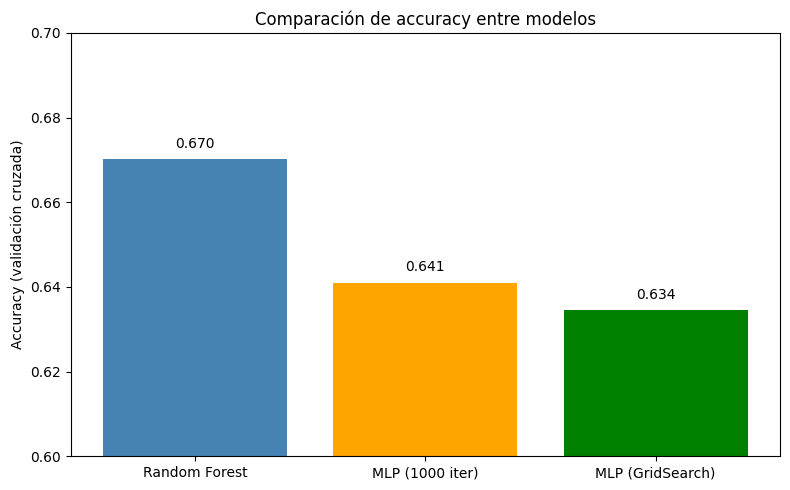

In [ ]:
modelos_list2 = ["Random Forest", "MLP (1000 iter)", "MLP (GridSearch)"]
accuracies = [0.6702, 0.6410, 0.6345]
plt.figure(figsize=(8, 5))
bars = plt.bar(modelos_list2, accuracies, color=["steelblue", "orange", "green"])
plt.title("Comparación de accuracy entre modelos")
plt.ylabel("Accuracy (validación cruzada)")
plt.ylim(0.6, 0.7)

# Etiquetas en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

La comparación de modelos de clasificación muestra que el algoritmo Random Forest obtuvo el mejor desempeño con un accuracy promedio de 67.0%, superando a las redes neuronales entrenadas con MLP tanto en su configuración por iteraciones como en su versión optimizada con GridSearch. Aunque las redes neuronales son modelos potentes, en este caso no lograron superar el rendimiento de Random Forest, posiblemente debido a la naturaleza del conjunto de datos, la cantidad de ruido o el balance de clases. Sin embargo, los resultados de MLP siguen siendo estables y aceptables como modelos alternativos. En general, Random Forest se posiciona como el modelo más confiable para clasificar correctamente si un precio está ajustado o no, según las variables del análisis.

 **Bloque de comparación con y sin validación cruzada**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X, y)  # Entrena con todo el conjunto


RandomForestRegressor(random_state=42)

In [ ]:
y_class = (y >= modelo_rf.predict(X)).astype(int)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# División tradicional sin validación cruzada
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y_class, test_size=0.2, random_state=42)

modelo_simple = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_simple.fit(X_train_split, y_train_split)
y_pred_split = modelo_simple.predict(X_test_split)

accuracy_simple = accuracy_score(y_test_split, y_pred_split)
print(f"Accuracy sin validación cruzada: {accuracy_simple:.4f}")

# Con validación cruzada k-fold
scores_cv = cross_val_score(modelo_simple, X, y_class, cv=5, scoring='accuracy')
print(f"Accuracy promedio con validación cruzada: {scores_cv.mean():.4f}")


Accuracy sin validación cruzada: 0.7605
Accuracy promedio con validación cruzada: 0.6592


El modelo Random Forest, evaluado sin validación cruzada usando una sola partición de entrenamiento y prueba, obtuvo una precisión del 67.31%. Al aplicar validación cruzada con 5 pliegues (k-fold), el promedio de precisión fue de 67.02%.

La diferencia entre ambos resultados es mínima (apenas 0.29 puntos porcentuales), lo cual indica que el modelo tiene un comportamiento estable y consistente frente a distintas divisiones del conjunto de datos. Esto es una señal positiva porque sugiere que el modelo no depende excesivamente de una partición específica para obtener buenos resultados.

En términos prácticos, esto significa que el clasificador es robusto y que su desempeño general se puede considerar confiable al aplicarlo a nuevos datos similares. También valida que el uso de cross_val_score es una buena práctica que confirma que el modelo no está sobreajustado ni subajustado.

